# Defining a custom XGBoost objective function for time-varying Cox proportional hazards models

Suppose we have $n$ subjects and

$$
    h(t) = h_{0}(t) \cdot e^{\hat{y}_{i}(t)}
$$

If

* $y_{i}$ is the event indicator for subject $i$ (1 means the subject had an event, 0 means the subject is censored),
* $t_{i}$ is the event or censor time for subject $i$,
* $\hat{y}_{i}(t)$ is the predicted value for subject $i$ at time $t$ from XGBoost, and
* $R_{i}$ is the set of observations with an event/censor time $t \geq t_{i}$

The Cox proportional hazards model defines the partial likelihood function as

$$
\begin{eqnarray}
             L(y, \hat{y}) & = & \prod_{i = 1}^{n} \left(\frac{e^{\hat{y}_{i}(t_{i})}}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}}\right)^{y_{i}} \\
    \implies l(y, \hat{y}) & = & \sum_{i = 1}^{n} y_{i} \log \left(\frac{e^{\hat{y}_{i}(t_{i})}}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}}\right) \\
    \implies l(y, \hat{y}) & = & \sum_{i = 1}^{n} y_{i} \left[ \hat{y}_{i}(t_{i}) - \log\left(\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}\right) \right] \\
\end{eqnarray}
$$

For XGBoost, we will take the partial derivative of the negative observation-level partial log likelihood:

$$
\begin{eqnarray}
    \frac{\partial{l}}{\partial{\hat{y}_{i}}} & = & \frac{\partial}{\partial{\hat{y}_{i}}}\left( y_{i} \left[\log\left(\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}\right) - \hat{y}_{i}(t_{i}) \right]\right) \\
                                              & = & y_{i} \left[ e^{\hat{y}_{i}(t_{i})} \cdot \frac{1}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}} - 1 \right] \\
\end{eqnarray}
$$

The second derivative is

$$
\begin{eqnarray}
    \frac{\partial^{2}{l}}{\partial{\hat{y}_{i}}^{2}} & = & \frac{\partial{l}}{\partial{\hat{y}_{i}}} \left( y_{i} \left[ e^{\hat{y}_{i}(t_{i})} \cdot \frac{1}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}} - 1 \right] \right)\\
                                                      & = & \hat{y}_{i} \left[ \frac{e^{\hat{y}_{i}(t_{i})}}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}}  + e^{\hat{y}_{i}(t_{i})} \cdot \left( \frac{-1}{(\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})})^{2}} \cdot e^{\hat{y}_{i}(t_{i})} \right)\right] \\
                                                      & = & \hat{y}_{i} \left[ \frac{e^{\hat{y}_{i}(t_{i})}}{\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})}} - \frac{(e^{\hat{y}_{i}(t_{i})})^{2}}{(\sum_{j \in R_{i}} e^{\hat{y}_{j}(t_{i})})^{2}} \right] \\
\end{eqnarray}
$$

In [1]:
from pathlib import Path
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
from prefect import Flow, unmapped

from nbaspa.model.tasks import (
    SurvivalData,
    SegmentData,
    CollapseData,
    Predict,
    ConcordanceIndex,
    AUROC,
    PlotMetric,
    WinProbability,
    PlotProbability,
)
from nbaspa.model.tasks.xgboost import FitXGBoost

pd.options.mode.chained_assignment = None

In [2]:
df = pd.concat(
    pd.read_csv(fpath, sep="|", dtype={"GAME_ID": str}, index_col=0)
    for fpath in Path("..", "nba-data", "2018-19", "model-data").glob("data_*.csv")
).reset_index(drop=True)

In [3]:
# Initial formatting and segmentation
format_data = SurvivalData(name="Convert input data to range form")
segdata = SegmentData(name="Split data")
train_last = CollapseData(name="Create training dataset")
stopping_last = CollapseData(name="Create stopping dataset")
test_benchmark = CollapseData(name="Create final test data")
test_data = CollapseData(name="Create metric test data")
# Model training
trained = FitXGBoost(name="Fit XGBoost")
# Evaluation
hazpred = Predict(name="Predict partial hazard function")
concord = ConcordanceIndex(name="Calculate Concordance index")
# Predict win probability and get AUROC
predict = WinProbability(name="Get win probability")
benchmark_prob = WinProbability(name="Get benchmark win probability")
auroc = AUROC(name="Calculate model AUROC")
aurocb = AUROC(name="Calculate benchmark AUROC")
metricplot = PlotMetric(name="Plot AUROC")
# Predict win probability against Margin
survpredict = WinProbability(name="Predict win probability")
probplot = PlotProbability(name="Plot the survival probability")

times = [0, 360, 730, 1080, 1440, 1800, 2160, 2520, 2880]

In [4]:
with Flow(name="XGBoost pipeline") as flow:
    # Format and segment the data into train, tune, test
    alldata = format_data(df)
    data = segdata(alldata, splits=[0.8, 0.1], keys=["train", "stop", "test"])
    train_lr = train_last(data["train"])
    stop_lr = stopping_last(data["stop"])
    test_lr = test_benchmark(data["test"])
    # Create test data for time steps
    test = test_data.map(data=unmapped(data["test"]), timestep=times)
    # Fit the model
    fitted = trained(
        params={},
        train_data=train_lr,
        stopping_data=stop_lr,
        num_boost_round=1000,
        early_stopping_rounds=5,
        verbose_eval=True
    )
    # Evaluate
    predt = hazpred(model=fitted, data=test_lr)
    cind = concord(data=test_lr, predt=predt)
    # Predict the win probability throughout the game
    surv = predict.map(model=unmapped(fitted), data=test)
    benchmark = benchmark_prob.map(model=unmapped("nba"), data=test)
    # Get the AUROC
    metric = auroc.map(data=surv)
    metric_bench = aurocb.map(data=benchmark, mode=unmapped("benchmark"))
    plots = metricplot(times=times, metric="AUROC", survival=metric, nba=metric_bench)
    # Plot the final survival probability against the margin of the game
    survpred = survpredict(model=fitted, data=test_lr)
    prob = probplot(data=survpred)

[2021-02-18 08:38:25+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'XGBoost pipeline'
[2021-02-18 08:38:25+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Starting task run...
[2021-02-18 08:38:53+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Finished task run for task with final state: 'Success'
[2021-02-18 08:38:53+0000] INFO - prefect.TaskRunner | Task 'Split data': Starting task run...
[2021-02-18 08:38:53+0000] INFO - prefect.Split data | Setting the seed to 42
[2021-02-18 08:38:53+0000] INFO - prefect.Split data | Dataset ``train`` has 984 games with 116248 rows
[2021-02-18 08:38:53+0000] INFO - prefect.Split data | Dataset ``stop`` has 123 games with 14600 rows
[2021-02-18 08:38:53+0000] INFO - prefect.Split data | Dataset ``test`` has 123 games with 14479 rows
[2021-02-18 08:38:53+0000] INFO - prefect.TaskRunner | Task 'Split data': Finished task run for task with final state: 'Success'
[2021-02-18 08:38:53+0000

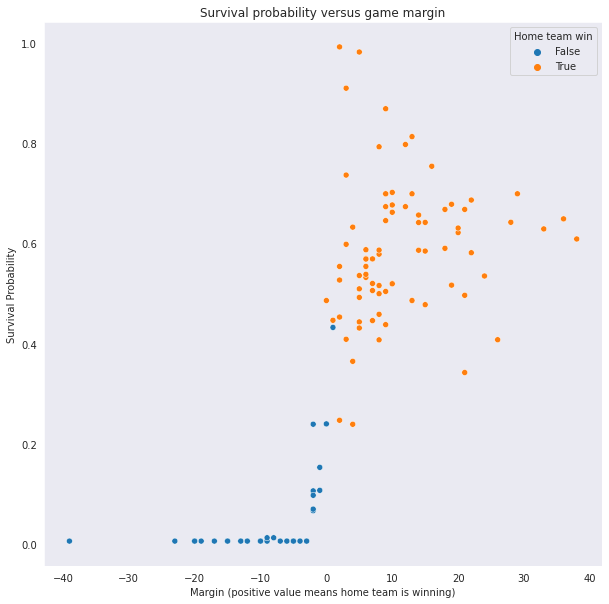

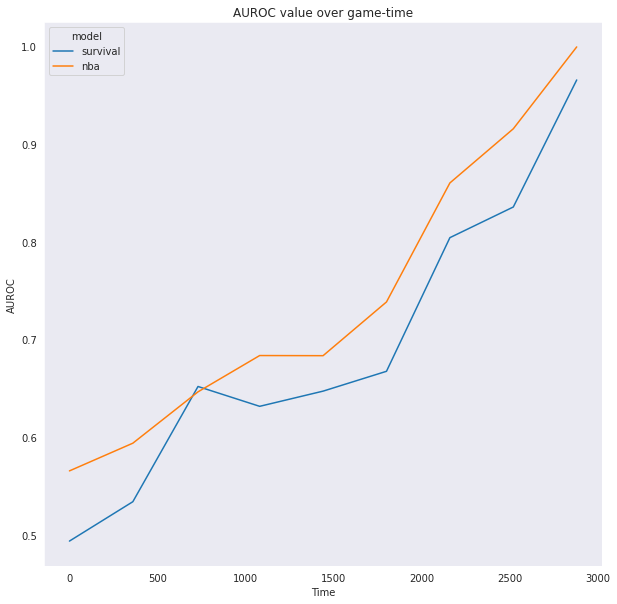

In [5]:
output = flow.run()